# Density of States

## Introduction

The density of states calculation workflow uses a hybride approach. It uses both ASE and Quantum Espresso functionalities. 

The tutorial files associated in this example can by found here: [link to files](https://github.com/kimrojas/digital-alchemy/tree/main/book/files/qe_tutorial/03_dos)

## Workflow

The workflow of the DOS calculation is as follows:

1. SCF calculation
2. non-SCF calculation
3. DOS calculation

All of these workflow steps are handled by the python file via ASE so it is convenient. In traditional workflow, you need to keep track of multiple files to run this. 

## Files

Same as before, you have 3 basic files:

|File | Description|
|---|---|
|SLURM script | Submits the job to the cluster with required resources and environment |
|Python script | Controls the workflow |
|Structure file | Contains the atomic positions and lattice vectors of your system |

### Python file

There isn't much change with the other two files, but the python file has more lines of code to handle the DOS calculation. Here is a short "pseudo-code" for the workflow, **the actual code is in the python file**.

```python
import all_the_necessary_modules

# 1. Get structure
atm = read("pristine_vdw.vasp")

# 2. Setup the input parameters
kpts_SCF = (4, 4, 1)
kpts_NSCF = (16, 16, 1)

input_data_scf = ...
input_data_nscf = deepcopy(input_data_scf)
input_data_nscf["control"]["calculation"] = "nscf"

pseudopotential = ...

# 3 RUN SCF CALCULATION
atm.set_calculator = Espresso(input_data=input_data_scf, 
                              pseudopotentials=pseudopotential, 
                              label="DFT/espresso_scf
                              kpts=kpts_SCF,)
atm.calc.calculate(atm)

# 4 RUN NSCF CALCULATION
atm.set_calculator = Espresso(input_data=input_data_nscf, 
                              pseudopotentials=pseudopotential, 
                              label="DFT/espresso_nscf
                              kpts=kpts_NSCF,)
atm.calc.calculate(atm)

# 5 RUN DOS CALCULATION
# 5.a prepare input file
with open("DFT/projwfc.inp", "w") as f:
    f.write("... INPUT FILE STRINGS ...")

run("projwfc.x < projwfc.inp > projwfc.out", shell=True, cwd="DFT")
```

As you can see, the steps 3, 4, and 5 are the most important ones in the workflow. 


### Output files

You may be surprised when you see that there are actually a lot of produced output files. Here are a rough lineup:

1. SCF output file
2. NSCF output file
3. DOS (projwfc) output file
4. DOS (dos data) output file (a lot of this)

From here you just need two data:

1. Fermi energy from SCF output file
2. DOS data from DOS output file

Here is a simple example on how to plot this:


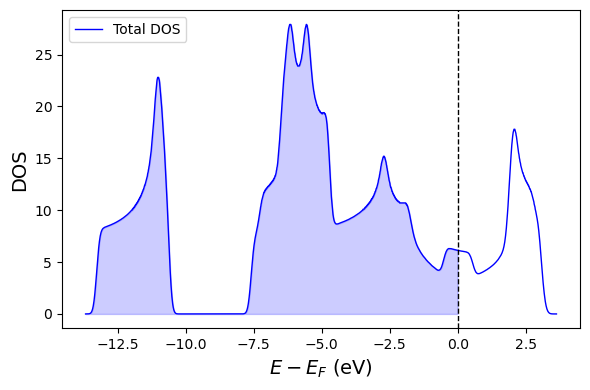

In [1]:
from ase.io import read
from pathlib import Path
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
from subprocess import check_output
import pandas as pd

cwd = Path.cwd()
bookdir = list(cwd.parents)[2]
filedir = bookdir / "files/qe_tutorial/03_dos/DFT"

# FIND FERMI ENERGY
scf_output = filedir / "espresso_scf.pwo"
line = check_output(f"grep Fermi {scf_output}", shell=True).decode()
fermi =  float(line.split()[-2])

# GET DOS DATA
# This is just an example using total dos, plot the atom projected dos if needed
dos_data_file = filedir / "base.pdos_tot"
dos_data = pd.read_csv(dos_data_file, header=None, skiprows=1, 
                       delim_whitespace=True, usecols=[0, 1], 
                       names=['energy', 'dos'],)
# Adjust energy to Fermi energy level
dos_data['energy'] = dos_data['energy'] - fermi



# PLOT DATA
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(dos_data['energy'], dos_data['dos'], label="Total DOS", color='blue', lw=1)
ax.fill_between(dos_data['energy'], dos_data['dos'], color='blue', alpha=0.2, where=dos_data['energy'] < 0)
ax.axvline(0, color='black', ls='--', lw=1)

ax.set_xlabel(r"$E - E_F$ (eV)", fontsize=14)
ax.set_ylabel("DOS", fontsize=14)
ax.legend()

fig.tight_layout()
